In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

from collections import Counter

Load data

In [2]:
raw_data = pd.read_csv('../pysurv/IPD.Mok.A.csv')
print("The raw_dataset has the following shape: {}.".format(raw_data.shape))
raw_data.head(2)

The raw_dataset has the following shape: (1217, 3).


,time,event,arm
0,0.561039,1,0
1,0.561039,1,0


In [3]:
raw_data.tail(2)

,time,event,arm
1215,21.128774,0,1
1216,21.128774,0,1


EDA

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1217 non-null   float64
 1   event   1217 non-null   int64  
 2   arm     1217 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 28.6 KB


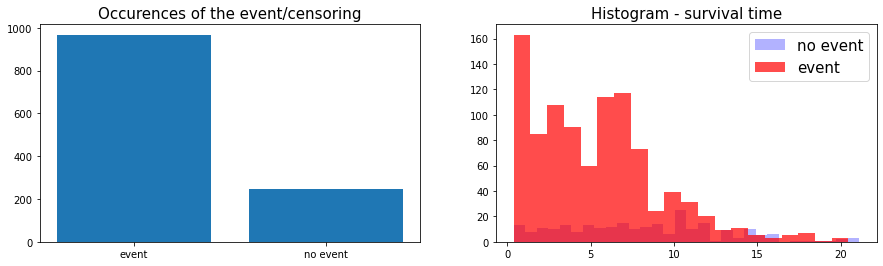

In [5]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_data['event'].replace({0:'no event', 1:'event'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_data.loc[ raw_data['event'] == 0, 'time']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'no event')

# Showing the histogram of the survival times for the events
time_1 = raw_data.loc[ raw_data['event'] == 1, 'time']
ax2.hist(time_1, bins=20, alpha=0.7, color='red', label = 'event')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

In [6]:
# Creating one-hot vectors
categories = ['arm']
dataset = pd.get_dummies(raw_data, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'time'
event_column = 'event'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [7]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 1001 duplicates


Modeling

In [8]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [9]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

np.seterr(divide='ignore', invalid='ignore')

#Creating an instance of the Conditional model and fitting the data.
# Building the model
rsf = RandomSurvivalForestModel(num_trees=10000)

rsf.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = 5,
    min_node_size = 10, num_threads = -1, weights = None,
    sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
    seed = None, save_memory=False )

RandomSurvivalForestModel

In [11]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(rsf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.59


The C-index represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but if it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

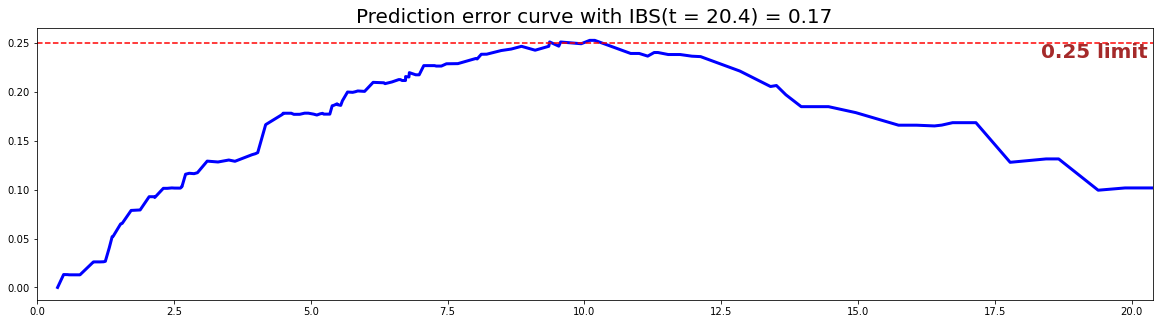

IBS: 0.17


In [12]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(rsf, X_test, T_test, E_test, t_max=35,
    figure_size=(20,5))
print('IBS: {:.2f}'.format(ibs))

The Brier score measures the average discrepancies between the status and the estimated probabilities at a given time. Thus, the lower the score (usually below 0.25), the better the predictive performance. To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well.

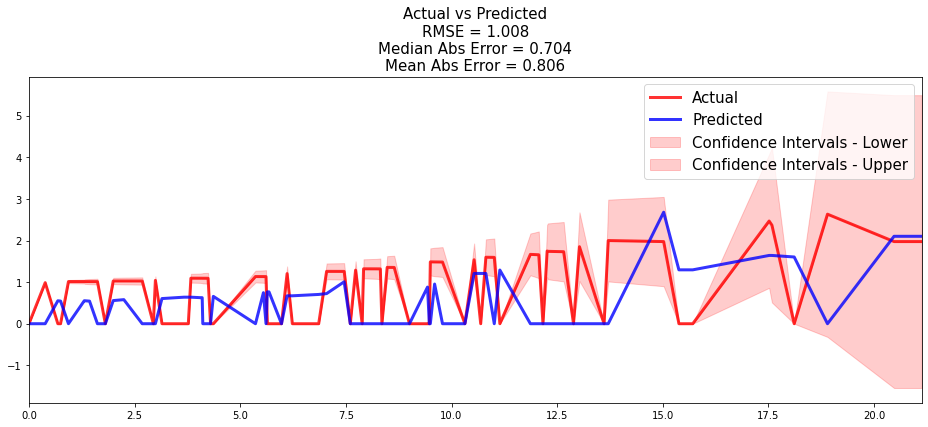

In [13]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(rsf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

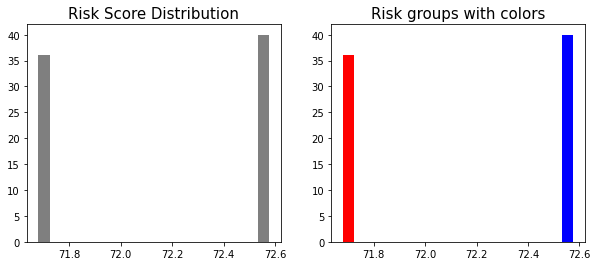

In [15]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=rsf, X=X_test,
    use_log = False, num_bins=20, figure_size=(10, 4),
    experimental={'lower_bound':66, 'upper_bound':72, 'color':'red'},
    control={'lower_bound':72, 'upper_bound':73,  'color':'blue'}
    )

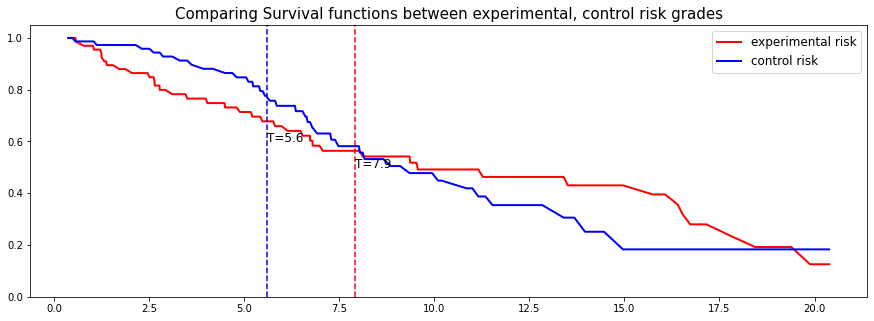

In [16]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = rsf.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(rsf.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()